# Twitter-RoBERTa Sentiment Analysis Notebook

This notebook executes the Twitter-RoBERTa sentiment analysis pipeline and visualizes the results.

**Model:** `cardiffnlp/twitter-roberta-base-sentiment-latest`
- Trained on ~124M tweets, fine-tuned on ~60K sentiment-labeled tweets
- Native 3-class output: negative, neutral, positive (no manual thresholds)
- Score = P(positive) - P(negative), range: -1 to +1

In [1]:
import sys

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the project root is in the path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.sentiment_twitter import TwitterSentimentAnalysis
from src.sentiment_evaluation import evaluate_sentiment
from src.config import DATA_PATHS

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 1. Run Twitter-RoBERTa Sentiment Analysis Pipeline

We will initialize and run the `TwitterSentimentAnalysis` pipeline. This will:
1. Load the preprocessed data.
2. Convert emojis to text (demojize).
3. Run Twitter-RoBERTa inference (3-class: positive/neutral/negative).
4. Evaluate against star ratings.
5. Save the results.

In [2]:
# Initialize and run the pipeline
analyzer = TwitterSentimentAnalysis()
success = analyzer.run_pipeline()

if success:
    print("Pipeline executed successfully.")
else:
    print("Pipeline failed.")

🚀 Using device: CPU
Loading Twitter-RoBERTa Sentiment Analysis Pipeline...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


STARTING TWITTER-ROBERTA SENTIMENT ANALYSIS PIPELINE

[1/4] Loading data from: ../data/processed/reviews_processed.csv
Preprocessing: Converting emojis to text...
✅ Loaded and preprocessed 9848 reviews.

[2/4] Running inference...


100%|██████████| 9848/9848 [04:51<00:00, 33.79it/s]



[3/4] Processing scores...

Sentiment Distribution:
sentiment_label
positive    59.199838
negative    21.405361
neutral     19.394801
Name: proportion, dtype: float64

Per-Bank Mean Sentiment Score by Star Rating:
rating                           1      2      3      4      5
bank_name                                                     
Abyssinia Bank              -0.679 -0.497 -0.141  0.330  0.560
Commercial Bank of Ethiopia -0.474 -0.365  0.031  0.422  0.634
Dashen Bank                 -0.657 -0.428 -0.178  0.400  0.733

[4/4] Evaluating and saving...

SENTIMENT EVALUATION: Twitter-RoBERTa
Reviews evaluated: 9848

--- 3 Essential Metrics ---
  Overall Accuracy:      72.1%
  Negative Recall:       71.5%    ← Did we catch the complaints?
  Score-Rating Corr:     0.705

--- Full Classification Report ---
              precision    recall  f1-score   support

    negative       0.73      0.72      0.72      2151
     neutral       0.08      0.27      0.13       576
    positive       0

## 1.5 Evaluation & Coverage Check

Evaluate Twitter-RoBERTa sentiment predictions against star ratings as ground truth:
- **1-2 stars** → negative
- **3 stars** → neutral
- **4-5 stars** → positive

Three essential metrics: **Overall Accuracy**, **Negative Recall** (did we catch the complaints?), **Score-Rating Correlation**.

In [3]:
# Evaluate sentiment predictions against star ratings
df_eval = pd.read_csv(DATA_PATHS['sentiment_results_twitter'])
eval_results = evaluate_sentiment(df_eval, model_name='Twitter-RoBERTa')


SENTIMENT EVALUATION: Twitter-RoBERTa
Reviews evaluated: 9848

--- 3 Essential Metrics ---
  Overall Accuracy:      72.1%
  Negative Recall:       71.5%    ← Did we catch the complaints?
  Score-Rating Corr:     0.705

--- Full Classification Report ---
              precision    recall  f1-score   support

    negative       0.73      0.72      0.72      2151
     neutral       0.08      0.27      0.13       576
    positive       0.93      0.76      0.84      7121

    accuracy                           0.72      9848
   macro avg       0.58      0.58      0.56      9848
weighted avg       0.83      0.72      0.77      9848



In [4]:
# Coverage Check (Rubric KPI: >90% of reviews must have sentiment scores)
coverage = df_eval['sentiment_score'].notna().mean() * 100
print(f'Sentiment Coverage: {coverage:.1f}%')
if coverage >= 90:
    print('✅ Coverage meets rubric requirement (>90%)')
else:
    print(f'⚠️ Coverage below 90% threshold — {100 - coverage:.1f}% reviews missing scores')

Sentiment Coverage: 100.0%
✅ Coverage meets rubric requirement (>90%)


## Evaluation Metrics Analysis
### Twitter-RoBERTa Sentiment Analysis shows a significant improvement in performance over the Vader Sentiment Analysis.
### The overall corelation with score is 70% compared to Vader's 50%- This is a significant improvement.
### The model's overall accuracy is 72% compared to Vader's 66%. The biggest improvemnt in this model is that it catched 72% of the negative reviews while vader only caught 40%.
###  This model still struggles with neutral reveiws , this can be because of our evalutaion metrics we are using the ratings as the ground truth . 3 expecting to be neutral but when we see the sentiment mean score at rating 3 it is slighly negative for Dashen and Abbyssina.This could mean that the users are rating 3 thinking that it is a negative review but we logically expect it to be neutral.
## This model is excellent with positive reviews - when it tags as positive it is 93% of the time correct.


## 2. Data Analysis & Visualization

Now that we have the sentiment scores, let's analyze the results. We will look at the distribution of sentiments and explore some examples.

In [5]:
# Load the results
df_sentiment = pd.read_csv(DATA_PATHS['sentiment_results_twitter'])
print(f'Loaded {len(df_sentiment)} analyzed reviews.')
df_sentiment.head()

Loaded 9848 analyzed reviews.


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,sentiment_score,sentiment_label
0,df20cbb3-6c0a-407b-9b4c-c761713ce51e,it crush every time you opend it it is hard to...,1,2026-02-17,2026,2,Abyssinia,Abyssinia Bank,Yohannes Tariku,0,71,Google Play,-0.869497,negative
1,c15244f8-25e1-4fca-9ed1-daf0e9ac0e2e,it is a best app,5,2026-02-16,2026,2,Abyssinia,Abyssinia Bank,gadisa worku,0,16,Google Play,0.975001,positive
2,5bc9361c-080d-46e3-8671-94ac9f69c029,"this app is useless, i try to use it but the a...",1,2026-02-15,2026,2,Abyssinia,Abyssinia Bank,Fitsum Alemayehu,0,166,Google Play,-0.944127,negative
3,2b184e78-5b24-4948-af50-ea702dc35ebd,"It’s very hard, it’s not working.👎👎",1,2026-02-11,2026,2,Abyssinia,Abyssinia Bank,Yemaryam lij Yemaryam lij,0,35,Google Play,-0.884460,negative
4,b642100d-0a91-4481-8719-d1ca5d02d5a2,v.good,5,2026-02-11,2026,2,Abyssinia,Abyssinia Bank,Zerihun Beyene,0,6,Google Play,0.751998,positive


C:\Users\yeget\AppData\Local\Temp\ipykernel_31272\476922792.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sentiment, x='sentiment_label', order=order, palette=colors, ax=ax)


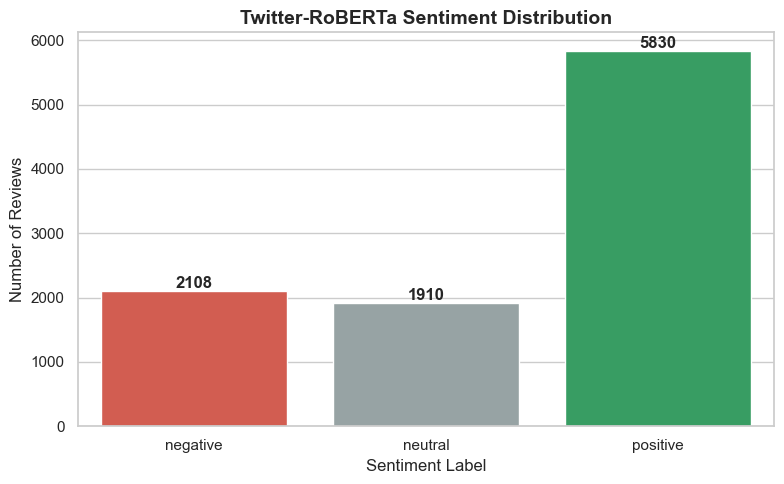

In [6]:
# Sentiment Label Distribution
fig, ax = plt.subplots(figsize=(8, 5))
order = ['negative', 'neutral', 'positive']
colors = ['#e74c3c', '#95a5a6', '#27ae60']
sns.countplot(data=df_sentiment, x='sentiment_label', order=order, palette=colors, ax=ax)
ax.set_title('Twitter-RoBERTa Sentiment Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Number of Reviews')

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

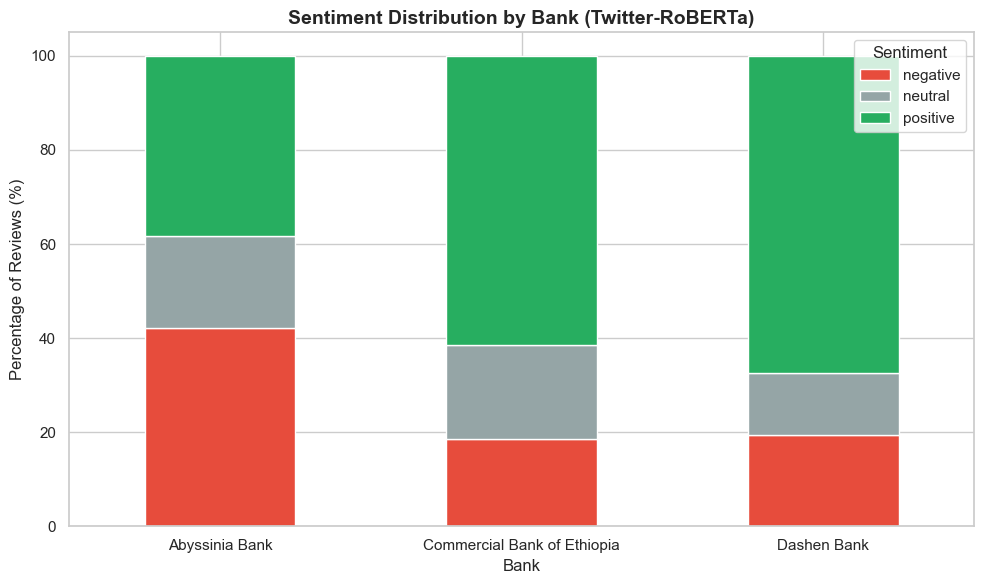

In [7]:
# Sentiment Distribution by Bank (Stacked Bar Chart)
# Create a cross-tabulation of Bank vs Sentiment
banks = df_sentiment['bank_name'].unique()
ct = pd.crosstab(df_sentiment['bank_name'], df_sentiment['sentiment_label'], normalize='index') * 100

# Reorder columns
ct = ct[['negative', 'neutral', 'positive']]
colors = ['#e74c3c', '#95a5a6', '#27ae60']

ax = ct.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))
ax.set_title('Sentiment Distribution by Bank (Twitter-RoBERTa)', fontsize=14, fontweight='bold')
ax.set_xlabel('Bank')
ax.set_ylabel('Percentage of Reviews (%)')
ax.legend(title='Sentiment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Sentiment Distribution by Bank interpretation
## We can see that Abbysina Bank has more percentage of negative reviews compared to it's positive reviews. 40%+ negative. This indicates that the bank has a lot of issues with their customers.
## Commercial Bank and Dashen Bank have a similar sentiment distribution.  They both have 60%+ positive reviews. 

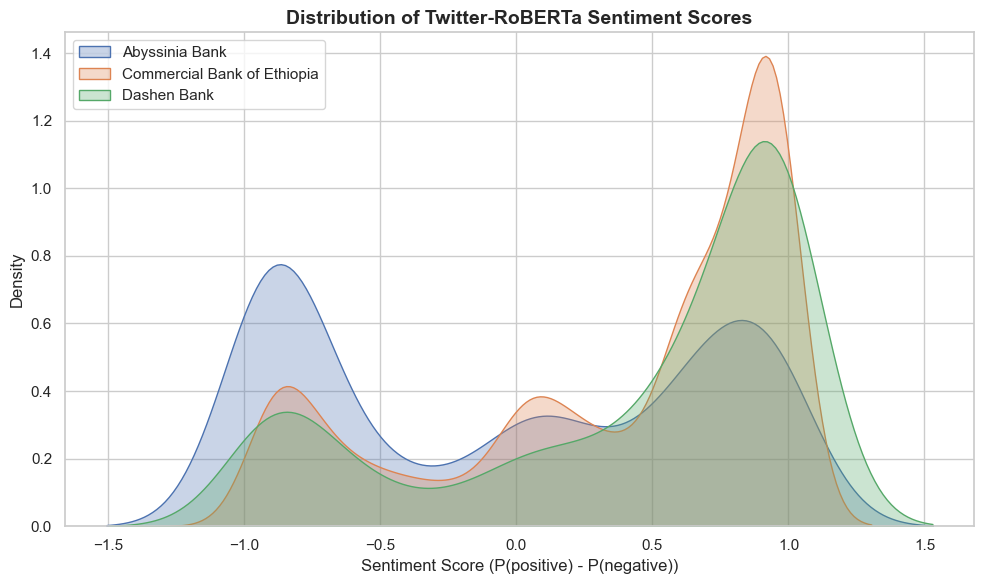

In [8]:
# Distribution of Sentiment Scores
fig, ax = plt.subplots(figsize=(10, 6))
for bank in df_sentiment['bank_name'].unique():
    bank_data = df_sentiment[df_sentiment['bank_name'] == bank]['sentiment_score']
    sns.kdeplot(bank_data, label=bank, ax=ax, fill=True, alpha=0.3)

ax.set_title('Distribution of Twitter-RoBERTa Sentiment Scores', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment Score (P(positive) - P(negative))')
ax.set_ylabel('Density')
ax.legend()
plt.tight_layout()
plt.show()

C:\Users\yeget\AppData\Local\Temp\ipykernel_31272\2101614102.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sentiment, x='rating', y='sentiment_score',


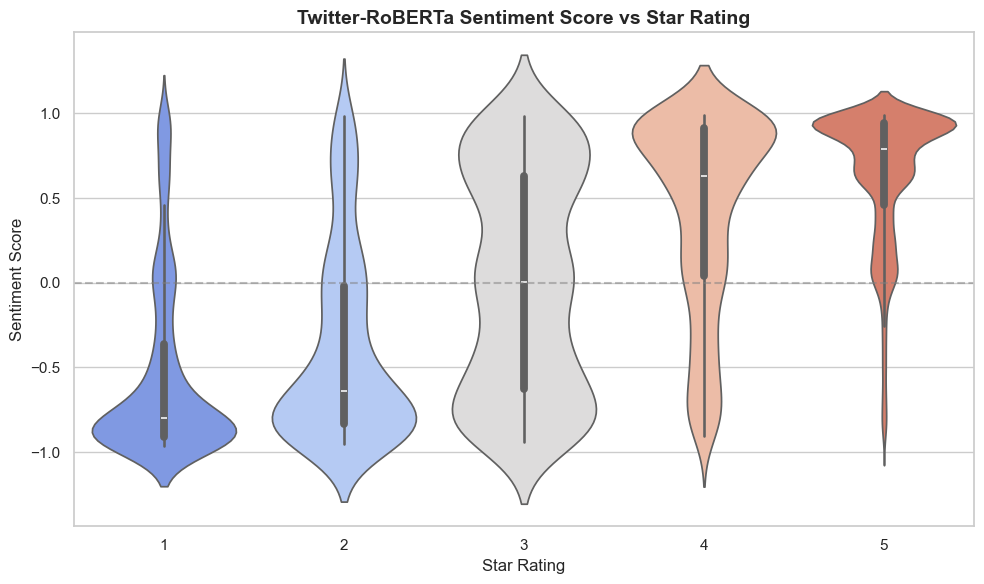

In [9]:
# Sentiment Score vs Star Rating (Violin Plot)
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=df_sentiment, x='rating', y='sentiment_score', 
               palette='coolwarm', ax=ax, inner='box')
ax.set_title('Twitter-RoBERTa Sentiment Score vs Star Rating', fontsize=14, fontweight='bold')
ax.set_xlabel('Star Rating')
ax.set_ylabel('Sentiment Score')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Violin plot interpretation
## We can see that ratings 1 and 2 have a lot of negative reviews, 1 having signicantly stronger negatives that 2.
## Rating 3 is not as expected as it should be , instead of sitting at 0 it has both negative and positive reviews. It even has extremly negatives and extremly positives. It spans the entire range of the plot. This also confirms our hypothesis for why the model performed poorly on rating 3. It's not that it performed poorly but because we used 3 as the ground truth in reality we see that 3 has a lot of both positive, neutral and negative reviews.
## Rating 4 is the most expected as it has a lot of positive reviews and very few negative reviews.
## Rating 5 is strongly positive as it has a lot of positive reviews and very few negative reviews.


# Final take on the model's low neutral score based on this violin plot and the metrics we can conclude:
## When the model says positive, it's right 93% of the time. When it says negative, it catches 72% of complaints. The 'poor' neutral performance isn't a model failure — it's because 3-star ≠ neutral sentiment. The model is reading the text correctly; the rating is the noisy label."


## Sentiment Score vs Star Rating Analysis

The violin plot above shows how the calculated sentiment score correlates with the user's actual star rating. A well-performing model should show:
- **Low ratings (1-2 stars):** Mostly negative scores
- **Mid ratings (3 stars):** Spread around zero
- **High ratings (4-5 stars):** Mostly positive scores

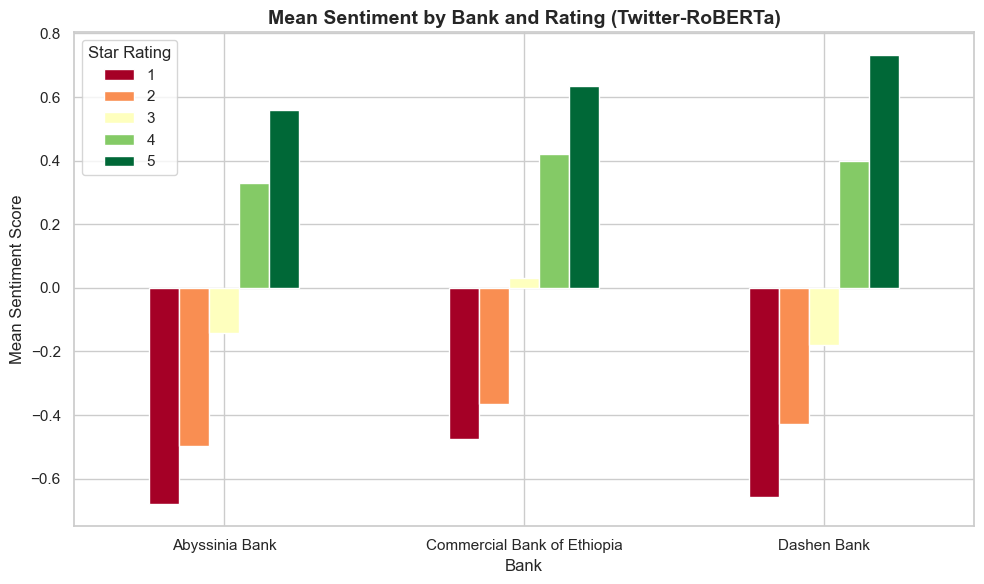

In [10]:
# Mean Sentiment Score by Bank and Rating
pivot = df_sentiment.groupby(['bank_name', 'rating'])['sentiment_score'].mean().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
pivot.plot(kind='bar', ax=ax, colormap='RdYlGn')
ax.set_title('Mean Sentiment by Bank and Rating (Twitter-RoBERTa)', fontsize=14, fontweight='bold')
ax.set_xlabel('Bank')
ax.set_ylabel('Mean Sentiment Score')
ax.legend(title='Star Rating')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## We can further see the sentiment-rating per bank here:
### Rating 3 is avergaing as negative review for both Dashen and Abyssinia. However, CBE's rating 3 is averaging as positive review.

In [11]:
## Print the time span for each bank
banks = df_sentiment['bank_code'].unique()
for bank in banks:
    bank_data = df_sentiment[df_sentiment['bank_code'] == bank]
    min_date = bank_data['review_date'].min()
    max_date = bank_data['review_date'].max()
    print(f'{bank}: {min_date} to {max_date} ({len(bank_data)} reviews)')

Abyssinia: 2024-02-05 to 2026-02-17 (1146 reviews)
CBE: 2018-12-13 to 2026-02-17 (7961 reviews)
Dashen: 2025-02-16 to 2026-02-16 (741 reviews)


C:\Users\yeget\AppData\Local\Temp\ipykernel_31272\3682763107.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = bank_data.resample('M', on='review_date')['sentiment_score'].mean()
C:\Users\yeget\AppData\Local\Temp\ipykernel_31272\3682763107.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = bank_data.resample('M', on='review_date')['sentiment_score'].mean()
C:\Users\yeget\AppData\Local\Temp\ipykernel_31272\3682763107.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = bank_data.resample('M', on='review_date')['sentiment_score'].mean()


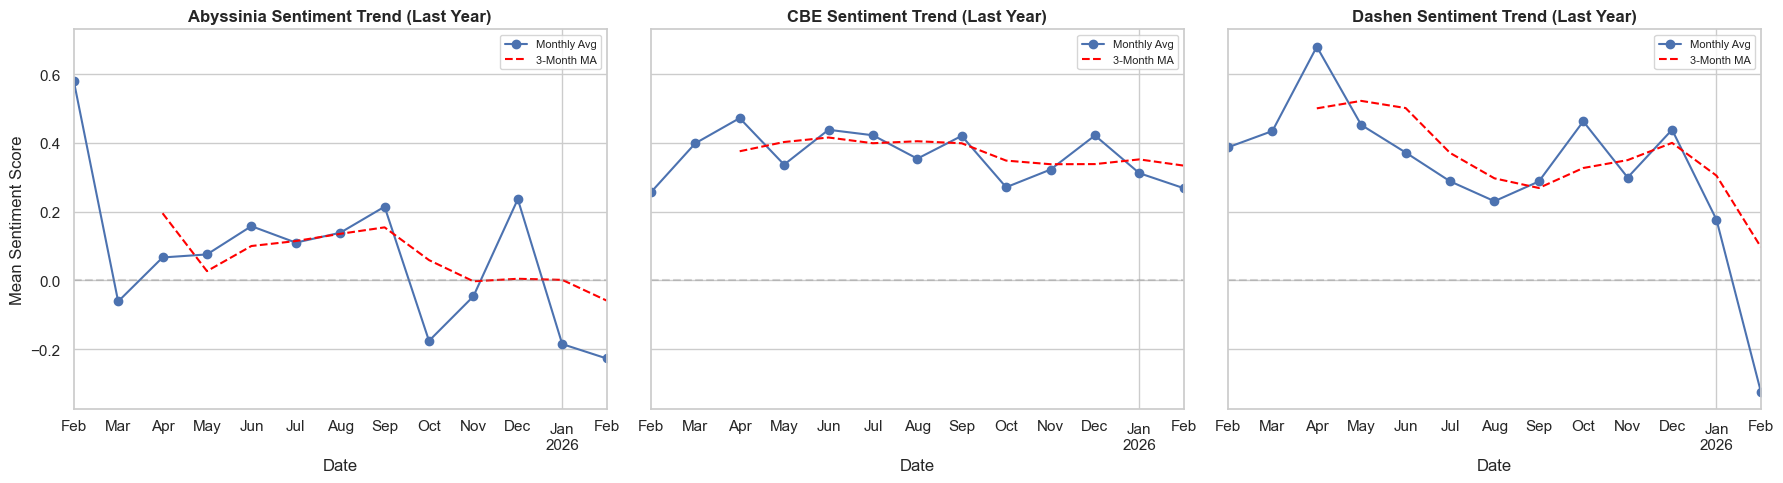

In [12]:
# Monthly Average Sentiment with Moving Average Trend
df_sentiment['review_date'] = pd.to_datetime(df_sentiment['review_date'])
one_year_ago = pd.Timestamp.now() - pd.DateOffset(years=1)
df_last_year = df_sentiment[df_sentiment['review_date'] >= one_year_ago]

fig, axes = plt.subplots(1, len(banks), figsize=(6*len(banks), 5), sharey=True)
if len(banks) == 1:
    axes = [axes]

for ax, bank in zip(axes, banks):
    bank_data = df_last_year[df_last_year['bank_code'] == bank].copy()
    monthly = bank_data.resample('M', on='review_date')['sentiment_score'].mean()
    monthly.plot(ax=ax, marker='o', label='Monthly Avg')
    monthly.rolling(3).mean().plot(ax=ax, linestyle='--', label='3-Month MA', color='red')
    ax.set_title(f'{bank} Sentiment Trend (Last Year)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Sentiment Score')
    ax.legend(fontsize=8)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## Time Series Analysis per Bank:
### Abyssinia's plot is concerning as it shows a strong negative trend starting from Sepember 2025. From January to February 2026, it shows a negative trend.
### CBE plot is somewhat stable with a few peaks and valleys. However, from January to Februray there is also a negative trend.
### Dashen plot is  showing a  steep donwnward trend. The most concerning is the steep decline from December 2025 to February, the downward slope is very steep!